In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from pennylane.templates.embeddings import AmplitudeEmbedding



# Data embedding
def data_embedding(X, embedding_type='Statevector'):
    if embedding_type == 'Amplitude':
        AmplitudeEmbedding(X, wires=range(8), normalize=True)
    elif embedding_type == 'Statevector':
        qml.QubitStateVector(X, wires = range(8))
    

# Ansatz
def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])
    
    
    
def Pooling_ansatz1(params, wires): #2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

def Pooling_ansatz2(wires): #0 params
    qml.CRZ(wires=[wires[0], wires[1]])

def Pooling_ansatz3(*params, wires): #3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])
    
    
    
    
# Quantum Circuits for Convolutional layers
def conv_layer1(U, params):
    U(params, wires=[0, 7])
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
def conv_layer2(U, params):
    U(params, wires=[0, 6])
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])
def conv_layer3(U, params):
    U(params, wires=[0,4])

# Quantum Circuits for Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])
def pooling_layer2(V, params):
    V(params, wires=[2,0])
    V(params, wires=[6,4])
def pooling_layer3(V, params):
    V(params, wires=[0,4])
    
    

# QCNN structure
def QCNN_structure(U, params, U_params):
    
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 3 * U_params + 2]
    param5 = params[3 * U_params + 2: 3 * U_params + 4]
    param6 = params[3 * U_params + 4: 3 * U_params + 6]

    # Pooling Ansatz1 is used by default
    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param4)
    conv_layer2(U, param2)
    pooling_layer2(Pooling_ansatz1, param5)
    conv_layer3(U, param3)
    pooling_layer3(Pooling_ansatz1, param6)
    
dev = qml.device('default.qubit', wires = 8)
@qml.qnode(dev)
def QCNN(X, params, U, U_params, embedding_type='Statevector', cost_fn='cross_entropy', nums_layer = 1):
# Data Embedding
    data_embedding(X, embedding_type=embedding_type)
    for layer in range(nums_layer):
        # Quantum Convolutional Neural Network
        if U == 'U_SU4':
            QCNN_structure(U_SU4, params, U_params)
        elif U == 'double_SU4':
            double_QCNN_structure(U_SU4, params, U_params)
        elif U == 'U_SU4_no_pooling':
            QCNN_structure_without_pooling(U_SU4, params, U_params)
        else:
            print("Invalid Unitary Ansatze")
            return False

    if cost_fn == 'mse':
        result = qml.expval(qml.PauliZ(4))
    elif cost_fn == 'cross_entropy':
        result = qml.probs(wires=4)
    return result   

    
    
    
    
# Generate Hamiltonian
def ising_hamiltonian(L, J, h):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sx_list = []
        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                x_ops = [id] * L
                z_ops[i_site] = pauli_z
                x_ops[i_site] = pauli_x
                ZZ = z_ops[0]
                X =  x_ops[0]
                for j in range(1, L):
                        ZZ = np.kron(ZZ, z_ops[j])
                        X = np.kron(X, x_ops[j])
                sz_list.append(ZZ)
                sx_list.append(X)
        H_zz = np.zeros((2**L, 2**L))
        H_x = np.zeros((2**L, 2**L))

        for i in range(L-1):
                H_zz += np.matmul(sz_list[i], sz_list[(i + 1)])
                H_x += sx_list[i]

        H_x += sx_list[L-1]

        return np.matrix(-J * H_zz - h * H_x)

# Magnetization operator
def M(L):
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                z_ops[i_site] = pauli_z
                Z = z_ops[0]
                for j in range(1, L):
                        Z = np.kron(Z, z_ops[j])
                sz_list.append(Z)
        H_z = np.zeros((2**L, 2**L))

        for i in range(L):
                H_z += sz_list[i]
        return np.matrix(H_z)/L
    
    

L = 8

h_list = np.arange(1)/2000
M_op = M(L)
ground_energies = []
ground_states = []
magnetization = []
for h in h_list:
    energy, state = eigh(ising_hamiltonian(L, 1, h), eigvals_only = False)
    ground_energies.append(min(energy))
    ground_states.append(state[:, np.argmin(energy)])
    ket = np.transpose([ground_states[-1]])
    m = np.matmul(np.matrix(ket).H, np.matmul(M_op, ket))
    magnetization.append(m.item())
    
    
    

# Regression model
params_ising_regression = np.array([0.34484976, -0.28182233, -0.97583034, -1.50284213, -1.575846,    1.65898698,
 -0.85920524,  0.40488789, -1.57277551,  0.44711323, -0.61537749, -0.39033801,
 -2.24276353, -2.64576165, -1.09133645, -0.33006222,  0.32891585,  0.47062225,
  0.17388104, -0.55350894,  0.05721447,  1.61864024,  1.57273429, -1.53038872,
 -0.00724897,  1.20235452,  0.01119348, -1.69642161,  0.13043329, -0.33715001,
  0.11057712,  0.47717991,  0.97122175,  1.30935699, -0.23240944, -0.66083709,
  0.04738152, -2.70902228,  0.06163599, -0.21079841,  0.77414923, -0.70443353,
  0.39859975, -0.31522218, -1.54637845, -0.57939689,  0.7585887,  -0.4308167,
  0.15577493, -1.06197993, -0.35725969], requires_grad=False)

def hybrid_job():
    pred_ising_regression = [QCNN(x, params_ising_regression, 'U_SU4', 15, 'Statevector', 'mse') for x in ground_states]
    
    return pred_ising_regression

job = hybrid_job()
print(job)
    
    



[tensor(0.99268263, requires_grad=True)]


# Functions

In [2]:
# Data embedding
def data_embedding(X, embedding_type='Statevector'):
    if embedding_type == 'Amplitude':
        AmplitudeEmbedding(X, wires=range(8), normalize=True)
    elif embedding_type == 'Statevector':
        qml.QubitStateVector(X, wires = range(8))

In [3]:
# Ansatz
def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])
    
    
    
def Pooling_ansatz1(params, wires): #2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

def Pooling_ansatz2(wires): #0 params
    qml.CRZ(wires=[wires[0], wires[1]])

def Pooling_ansatz3(*params, wires): #3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])

In [4]:
# Quantum Circuits for Convolutional layers
def conv_layer1(U, params):
    U(params, wires=[0, 7])
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
def conv_layer2(U, params):
    U(params, wires=[0, 6])
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])
def conv_layer3(U, params):
    U(params, wires=[0,4])

# Quantum Circuits for Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])
def pooling_layer2(V, params):
    V(params, wires=[2,0])
    V(params, wires=[6,4])
def pooling_layer3(V, params):
    V(params, wires=[0,4])

In [5]:
# QCNN structure
def QCNN_structure(U, params, U_params):
    
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 3 * U_params + 2]
    param5 = params[3 * U_params + 2: 3 * U_params + 4]
    param6 = params[3 * U_params + 4: 3 * U_params + 6]

    # Pooling Ansatz1 is used by default
    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param4)
    conv_layer2(U, param2)
    pooling_layer2(Pooling_ansatz1, param5)
    conv_layer3(U, param3)
    pooling_layer3(Pooling_ansatz1, param6)

In [6]:
dev = qml.device('default.qubit', wires = 8)
@qml.qnode(dev)
def QCNN(X, params, U, U_params, embedding_type='Statevector', cost_fn='cross_entropy', nums_layer = 1):
# Data Embedding
    data_embedding(X, embedding_type=embedding_type)
    for layer in range(nums_layer):
        # Quantum Convolutional Neural Network
        if U == 'U_SU4':
            QCNN_structure(U_SU4, params, U_params)
        elif U == 'double_SU4':
            double_QCNN_structure(U_SU4, params, U_params)
        elif U == 'U_SU4_no_pooling':
            QCNN_structure_without_pooling(U_SU4, params, U_params)
        else:
            print("Invalid Unitary Ansatze")
            return False

    if cost_fn == 'mse':
        result = qml.expval(qml.PauliZ(4))
    elif cost_fn == 'cross_entropy':
        result = qml.probs(wires=4)
    return result

# Ising model

## Generating testing dataset

In [7]:
# Generate Hamiltonian
def ising_hamiltonian(L, J, h):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sx_list = []
        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                x_ops = [id] * L
                z_ops[i_site] = pauli_z
                x_ops[i_site] = pauli_x
                ZZ = z_ops[0]
                X =  x_ops[0]
                for j in range(1, L):
                        ZZ = np.kron(ZZ, z_ops[j])
                        X = np.kron(X, x_ops[j])
                sz_list.append(ZZ)
                sx_list.append(X)
        H_zz = np.zeros((2**L, 2**L))
        H_x = np.zeros((2**L, 2**L))

        for i in range(L-1):
                H_zz += np.matmul(sz_list[i], sz_list[(i + 1)])
                H_x += sx_list[i]

        H_x += sx_list[L-1]

        return np.matrix(-J * H_zz - h * H_x)

# Magnetization operator
def M(L):
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                z_ops[i_site] = pauli_z
                Z = z_ops[0]
                for j in range(1, L):
                        Z = np.kron(Z, z_ops[j])
                sz_list.append(Z)
        H_z = np.zeros((2**L, 2**L))

        for i in range(L):
                H_z += sz_list[i]
        return np.matrix(H_z)/L

In [8]:
L = 8

h_list = np.arange(1000)/2000
M_op = M(L)
ground_energies = []
ground_states = []
magnetization = []
for h in h_list:
    energy, state = eigh(ising_hamiltonian(L, 1, h), eigvals_only = False)
    ground_energies.append(min(energy))
    ground_states.append(state[:, np.argmin(energy)])
    ket = np.transpose([ground_states[-1]])
    m = np.matmul(np.matrix(ket).H, np.matmul(M_op, ket))
    magnetization.append(m.item())

## Test and Analysis

In [9]:
# Regression model
params_ising_regression = np.array([0.34484976, -0.28182233, -0.97583034, -1.50284213, -1.575846,    1.65898698,
 -0.85920524,  0.40488789, -1.57277551,  0.44711323, -0.61537749, -0.39033801,
 -2.24276353, -2.64576165, -1.09133645, -0.33006222,  0.32891585,  0.47062225,
  0.17388104, -0.55350894,  0.05721447,  1.61864024,  1.57273429, -1.53038872,
 -0.00724897,  1.20235452,  0.01119348, -1.69642161,  0.13043329, -0.33715001,
  0.11057712,  0.47717991,  0.97122175,  1.30935699, -0.23240944, -0.66083709,
  0.04738152, -2.70902228,  0.06163599, -0.21079841,  0.77414923, -0.70443353,
  0.39859975, -0.31522218, -1.54637845, -0.57939689,  0.7585887,  -0.4308167,
  0.15577493, -1.06197993, -0.35725969], requires_grad=False)
pred_ising_regression = [QCNN(x, params_ising_regression, 'U_SU4', 15, 'Statevector', 'mse') for x in ground_states]

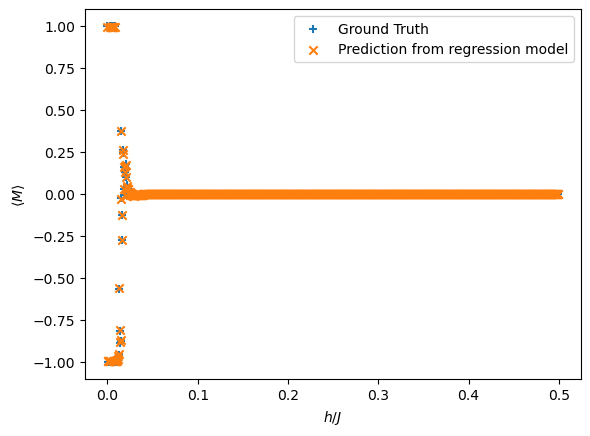

In [10]:
plt.scatter(h_list, magnetization, marker = '+', label = 'Ground Truth')
plt.scatter(h_list, pred_ising_regression, marker = "x", label = 'Prediction from regression model')
plt.xlabel(r"$h/J$")
plt.ylabel(r"$\langle M\rangle$")
plt.legend()
plt.savefig('plots/regression_ising.pdf')
plt.show()

# $Z_2\times Z_2$ SPT phase

## Generating Testig dataset

In [11]:
# Generate Hamiltonian
def spt_hamiltonian(L, J, h):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sx_list = []
        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                x_ops = [id] * L
                z_ops[i_site] = pauli_z
                x_ops[i_site] = pauli_x
                ZZ = z_ops[0]
                X =  x_ops[0]
                for j in range(1, L):
                        ZZ = np.kron(ZZ, z_ops[j])
                        X = np.kron(X, x_ops[j])
                sz_list.append(ZZ)
                sx_list.append(X)
        H_zxz = np.zeros((2**L, 2**L))
        H_xx = np.zeros((2**L, 2**L))

        for i in range(L-2):
                H_zxz += np.matmul(sz_list[i], np.matmul(sx_list[i+1], sz_list[(i + 2)]))
                H_xx += np.matmul(sx_list[i], sx_list[i+1])

        H_xx += np.matmul(sx_list[L-2], sx_list[L-1])

        return np.matrix(-J * H_zxz - h * H_xx)

def stringOp(L):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)
        
        ops = [id]*L
        if L%2 == 1:
                ops[0] = pauli_z
                ops[-1] = pauli_z
                for i in range(1, L-1, 2):
                        ops[i] = pauli_x
        elif L%2 == 0:
                ops[0] = pauli_z
                ops[L-2] = pauli_z 
                for i in range(1, L-2, 2):
                        ops[i] = pauli_x
        
        out = ops[0]
        for i in range(1, L):
                out = np.kron(out, ops[i])
                
        

        
        return out
        
        
        


In [12]:
# Generate ground states
L = 8

h_list_spt = (6*np.random.rand(1000) - 3)


ground_energies_spt = []
ground_states_spt = []

orderParams = []

op = stringOp(L)
for h in h_list_spt:
    energy, state = eigh(spt_hamiltonian(L, 1, h), eigvals_only = False)
    ground_energies_spt.append(min(energy))
    ground_states_spt.append(state[:, np.argmin(energy)])
    ket = np.transpose([ground_states_spt[-1]])
    m = np.matmul(np.matrix(ket).H, np.matmul(op, ket))
    orderParams.append(m.item())

## Test and Analysis

In [13]:
# Regression model
params_spt_regression = np.array([-0.35130076,  2.20147317,  0.4685366,  -0.11863158, -1.02904303,  0.23908072,
 -1.23517294,  0.27082562,  1.18944713,  0.05485146,  1.69398049,  0.98168833,
 -2.10962073, -0.8272562,   0.49564486, -1.56368582, -0.58283765,  0.83238825,
  0.01620159, -1.326686,   -0.41372758, -0.24921912, -2.30927844,  0.3357681,
  1.26383322, -1.44975513, -0.55086913,  1.07589775,  0.74656593, -2.29108514,
 -1.28677819,  1.81730066, -1.16639177,  2.20526573,  0.63912209,  0.30178217,
 -1.14256607,  0.70645885,  1.58831076, -0.85044413,  2.16992461, -0.72336096,
  0.68924927,  0.46234245, -2.07298505,  1.01307697,  0.64194001, -0.1594233,
 -1.12720285,  0.91683663,  2.22453806])
pred_spt_regression = [QCNN(x, params_spt_regression, 'U_SU4', 15, 'Statevector', 'mse') for x in ground_states_spt]

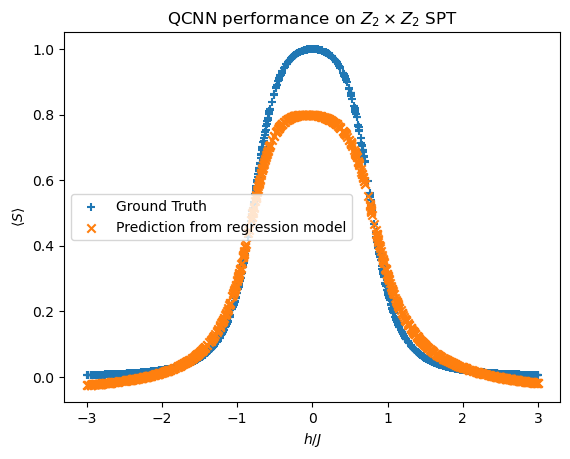

In [14]:
plt.scatter(h_list_spt, orderParams, marker = '+', label = 'Ground Truth')
plt.scatter(h_list_spt, pred_spt_regression, marker = "x", label = 'Prediction from regression model')
# plt.scatter(h_list_spt, pred_spt_regression_nonlocal, marker = "^", label = 'Prediction from regression model with nonlocal measurement')


plt.xlabel(r"$h/J$")
plt.ylabel(r"$\langle S\rangle$")
plt.legend()
plt.title(r'QCNN performance on $Z_2\times Z_2$ SPT')
plt.savefig('plots/regression_spt.pdf')
plt.show()